In [11]:
import pandas as pd

In [12]:
# Load the dataset from the datasets folder
dataset_path = '../traintestdata/Reddit_ideations.csv'
df = pd.read_csv(dataset_path)
print(df.head())
df.info()
df.isnull().sum()
df.describe(include='all')

     User                                               Post       Label
0  user-0  ['Its not a viable option, and youll be leavin...  Supportive
1  user-1  ['It can be hard to appreciate the notion that...    Ideation
2  user-2  ['Hi, so last night i was sitting on the ledge...    Behavior
3  user-3  ['I tried to kill my self once and failed badl...     Attempt
4  user-4  ['Hi NEM3030. What sorts of things do you enjo...    Ideation
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   User    500 non-null    object
 1   Post    500 non-null    object
 2   Label   500 non-null    object
dtypes: object(3)
memory usage: 11.8+ KB


,User,Post,Label
count,500,500,500
unique,500,500,5
top,user-0,"['Its not a viable option, and youll be leavin...",Ideation
freq,1,1,171


<h3>Clean Dataset

<p> Note, since I'm using a Roberta transformer, minimal data cleaning is required <p>

In [13]:
# remove user column
df = df.drop(columns=['User'])
# remove potential duplicates
df = df.drop_duplicates(subset=['Post', 'Label'])
# remove null values
df = df.dropna()
# add a column for the processed text
df['Processed'] = df['Post']

In [14]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
# tokenize
df['Processed'] = df['Processed'].apply(lambda x: word_tokenize(x))
# remove any links
df['Processed'] = df['Processed'].apply(lambda x: [i for i in x if ('http' or 'www') not in i])
# join tokens back together 
df['Processed'] = df['Processed'].apply(lambda x: ' '.join(x))
# Create less confusing labels
# the idea is that each label can indicate a level of severity
# potentially useful for training
label_map = {
    'Supportive': 0,
    'Ideation': 1,
    'Indicator': 2,
    'Behavior': 3,
    'Attempt': 4
}
df['numLabel'] = df['Label'].apply(lambda x: label_map[x])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zlyon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\zlyon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\zlyon\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [15]:
df.head()

,Post,Label,Processed,numLabel
0,"['Its not a viable option, and youll be leavin...",Supportive,"[ 'Its not a viable option , and youll be leav...",0
1,['It can be hard to appreciate the notion that...,Ideation,[ 'It can be hard to appreciate the notion tha...,1
2,"['Hi, so last night i was sitting on the ledge...",Behavior,"[ 'Hi , so last night i was sitting on the led...",3
3,['I tried to kill my self once and failed badl...,Attempt,[ ' I tried to kill my self once and failed ba...,4
4,['Hi NEM3030. What sorts of things do you enjo...,Ideation,[ 'Hi NEM3030 . What sorts of things do you en...,1


<h3> Plot trends of the data

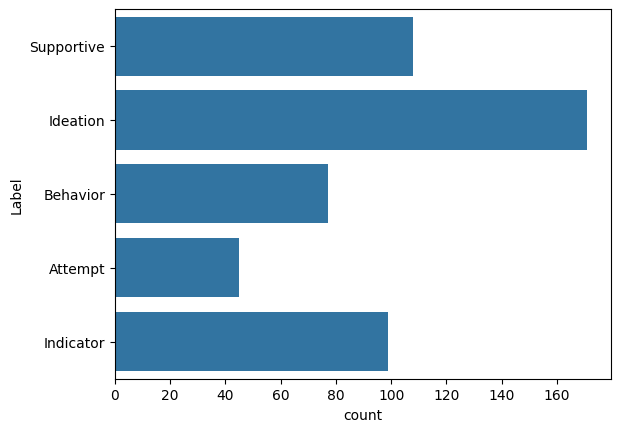

In [16]:
# show distribution of labels
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(df['Label'])
plt.show()

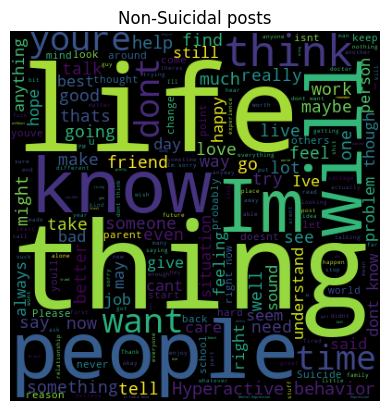

In [17]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
# create a word cloud of each label
wordcloud = WordCloud(width = 400, height = 400).generate(' '.join(df[df['numLabel'] == 0]['Post']))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Non-Suicidal posts')
plt.show()


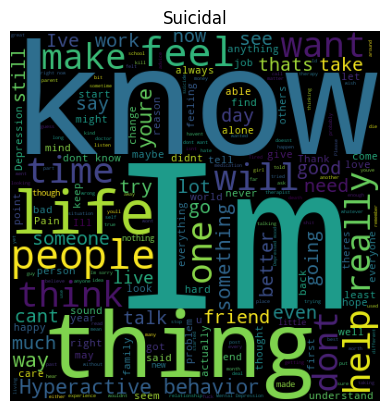

In [18]:
wordcloud = WordCloud(width = 400, height = 400).generate(' '.join(df[df['numLabel'] == 1]['Post']))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Suicidal')
plt.show()

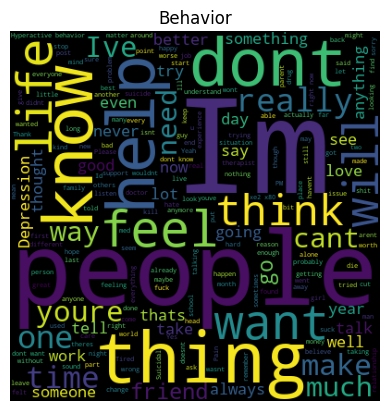

In [19]:
wordcloud = WordCloud(width = 400, height = 400).generate(' '.join(df[df['numLabel'] == 3]['Processed']))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Behavior')
plt.show()

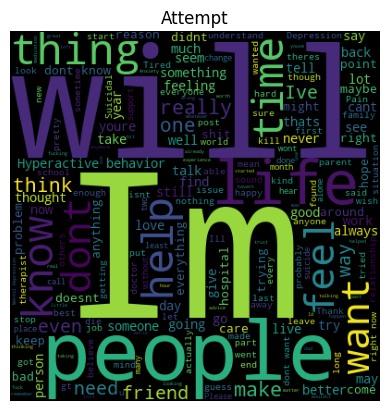

In [20]:
wordcloud = WordCloud(width = 400, height = 400).generate(' '.join(df[df['numLabel'] == 4]['Processed']))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Attempt')
plt.show()

<p>We can see that in the posts that have a higher than 0 ideation the focus tends to be about the individual <p>
<p>This may potentially cause a problem when training the model since in regular therapy one should talk about themselves <p>
<p>Another thing to note is that I should place less emphasis on words that appear in all 4 often <p>

<h3> Train Model

In [21]:
from sklearn.model_selection import train_test_split
from datasets import Dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=99)
# convert to hugging face dataset from pandas dataframe
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
train_dataset = train_dataset.rename_column("numLabel", "labels")
test_dataset = test_dataset.rename_column("numLabel", "labels")


In [22]:
%pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [23]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_name = "DistilRoBERTa-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)  # num_labels=2 for binary classification

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DistilRoBERTa-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
def tokenize(batch):
    return tokenizer(batch['Post'], padding=True, truncation=True, max_length=128)
train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# Set format for PyTorch
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


Map: 100%|██████████| 100/100 [00:00<00:00, 2173.70 examples/s]


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,               # Adjusted learning rate
    num_train_epochs=5,               # Fewer epochs to avoid overfitting
    per_device_train_batch_size=4,    # Adjust batch size based on memory
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,    # Reduce accumulation to allow larger batch size
    weight_decay=0.05,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",  # Use F1 for the best model metric
    greater_is_better=True
)




In [101]:
import torch
print(torch.cuda.is_available())

True


In [102]:
from transformers import Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

trainer = Trainer(
    model=model.to('cuda'),
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

 10%|█         | 50/500 [05:12<46:50,  6.25s/it]
                                               
  5%|▌         | 13/250 [00:00<00:13, 17.87it/s]

{'loss': 0.3556, 'grad_norm': 101.99002075195312, 'learning_rate': 2.88e-05, 'epoch': 0.2}


                                                
  9%|▉         | 23/250 [00:01<00:12, 18.53it/s]

{'loss': 0.3229, 'grad_norm': 29.474117279052734, 'learning_rate': 2.7600000000000003e-05, 'epoch': 0.4}


                                                
 14%|█▎        | 34/250 [00:01<00:11, 19.09it/s]

{'loss': 0.1185, 'grad_norm': 41.6505012512207, 'learning_rate': 2.64e-05, 'epoch': 0.6}


                                                
 18%|█▊        | 44/250 [00:02<00:10, 19.68it/s]

{'loss': 0.1948, 'grad_norm': 141.00143432617188, 'learning_rate': 2.52e-05, 'epoch': 0.8}


                                                
 20%|██        | 50/250 [00:02<00:10, 19.74it/s]

{'loss': 0.4449, 'grad_norm': 115.78983306884766, 'learning_rate': 2.4e-05, 'epoch': 1.0}






                                                
                                             
 20%|██        | 50/250 [00:02<00:10, 19.74it/s]


{'eval_loss': 3.990809440612793, 'eval_accuracy': 0.16, 'eval_f1': 0.10921827503289325, 'eval_precision': 0.15650793650793648, 'eval_recall': 0.13725490196078433, 'eval_runtime': 0.1402, 'eval_samples_per_second': 713.505, 'eval_steps_per_second': 178.376, 'epoch': 1.0}


                                                
 26%|██▌       | 64/250 [00:05<00:15, 12.33it/s]

{'loss': 0.2592, 'grad_norm': 38.289730072021484, 'learning_rate': 2.2800000000000002e-05, 'epoch': 1.2}


                                                
 30%|██▉       | 74/250 [00:05<00:10, 17.39it/s]

{'loss': 0.0991, 'grad_norm': 36.04994583129883, 'learning_rate': 2.16e-05, 'epoch': 1.4}


                                                
 34%|███▎      | 84/250 [00:06<00:08, 18.76it/s]

{'loss': 0.0535, 'grad_norm': 119.42343139648438, 'learning_rate': 2.04e-05, 'epoch': 1.6}


                                                
 37%|███▋      | 93/250 [00:06<00:08, 19.31it/s]

{'loss': 0.2563, 'grad_norm': 7.289835453033447, 'learning_rate': 1.9200000000000003e-05, 'epoch': 1.8}


                                                
 40%|████      | 100/250 [00:07<00:07, 19.80it/s]

{'loss': 0.2355, 'grad_norm': 63.12301254272461, 'learning_rate': 1.8e-05, 'epoch': 2.0}






                                                 
                                             
 40%|████      | 100/250 [00:07<00:07, 19.80it/s]


{'eval_loss': 3.970621109008789, 'eval_accuracy': 0.29, 'eval_f1': 0.21306277056277056, 'eval_precision': 0.2664791603745092, 'eval_recall': 0.2283846872082166, 'eval_runtime': 0.141, 'eval_samples_per_second': 709.033, 'eval_steps_per_second': 177.258, 'epoch': 2.0}


                                                 
 45%|████▍     | 112/250 [00:09<00:13, 10.14it/s]

{'loss': 0.0495, 'grad_norm': 1.6579140424728394, 'learning_rate': 1.6800000000000002e-05, 'epoch': 2.2}


                                                 
 50%|████▉     | 124/250 [00:10<00:07, 16.56it/s]

{'loss': 0.0646, 'grad_norm': 0.9719301462173462, 'learning_rate': 1.56e-05, 'epoch': 2.4}


                                                 
 53%|█████▎    | 132/250 [00:10<00:06, 18.57it/s]

{'loss': 0.0898, 'grad_norm': 0.6926068663597107, 'learning_rate': 1.44e-05, 'epoch': 2.6}


                                                 
 57%|█████▋    | 143/250 [00:11<00:05, 19.66it/s]

{'loss': 0.1281, 'grad_norm': 3.7034082412719727, 'learning_rate': 1.32e-05, 'epoch': 2.8}


                                                 
 60%|██████    | 150/250 [00:11<00:04, 20.06it/s]

{'loss': 0.0351, 'grad_norm': 2.2519052028656006, 'learning_rate': 1.2e-05, 'epoch': 3.0}






                                                 
                                             
 60%|██████    | 150/250 [00:11<00:04, 20.06it/s]


{'eval_loss': 4.655925750732422, 'eval_accuracy': 0.29, 'eval_f1': 0.2252887537993921, 'eval_precision': 0.23438378825475598, 'eval_recall': 0.22250233426704016, 'eval_runtime': 0.1417, 'eval_samples_per_second': 705.816, 'eval_steps_per_second': 176.454, 'epoch': 3.0}


                                                 
 66%|██████▌   | 164/250 [00:15<00:09,  9.40it/s]

{'loss': 0.0103, 'grad_norm': 20.481285095214844, 'learning_rate': 1.08e-05, 'epoch': 3.2}


                                                 
 69%|██████▉   | 172/250 [00:15<00:05, 14.39it/s]

{'loss': 0.0042, 'grad_norm': 1.4141128063201904, 'learning_rate': 9.600000000000001e-06, 'epoch': 3.4}


                                                 
 74%|███████▎  | 184/250 [00:16<00:03, 18.56it/s]

{'loss': 0.0765, 'grad_norm': 5.033936023712158, 'learning_rate': 8.400000000000001e-06, 'epoch': 3.6}


                                                 
 77%|███████▋  | 193/250 [00:16<00:02, 19.50it/s]

{'loss': 0.0371, 'grad_norm': 0.8913397192955017, 'learning_rate': 7.2e-06, 'epoch': 3.8}


                                                 
 80%|████████  | 200/250 [00:17<00:02, 19.99it/s]

{'loss': 0.075, 'grad_norm': 0.4781477451324463, 'learning_rate': 6e-06, 'epoch': 4.0}






                                                 
                                             
 80%|████████  | 200/250 [00:17<00:02, 19.99it/s]


{'eval_loss': 4.706692695617676, 'eval_accuracy': 0.31, 'eval_f1': 0.22294346763792844, 'eval_precision': 0.2322624743677375, 'eval_recall': 0.2215686274509804, 'eval_runtime': 0.1365, 'eval_samples_per_second': 732.56, 'eval_steps_per_second': 183.14, 'epoch': 4.0}


                                                 
 86%|████████▌ | 214/250 [00:19<00:03, 10.72it/s]

{'loss': 0.0083, 'grad_norm': 0.18722942471504211, 'learning_rate': 4.800000000000001e-06, 'epoch': 4.2}


                                                 
 89%|████████▉ | 222/250 [00:20<00:01, 15.05it/s]

{'loss': 0.004, 'grad_norm': 0.03947851434350014, 'learning_rate': 3.6e-06, 'epoch': 4.4}


                                                 
 94%|█████████▎| 234/250 [00:20<00:00, 18.87it/s]

{'loss': 0.0036, 'grad_norm': 0.6221107840538025, 'learning_rate': 2.4000000000000003e-06, 'epoch': 4.6}


                                                 
 97%|█████████▋| 243/250 [00:21<00:00, 19.57it/s]

{'loss': 0.0022, 'grad_norm': 0.2117432802915573, 'learning_rate': 1.2000000000000002e-06, 'epoch': 4.8}


                                                 
100%|██████████| 250/250 [00:21<00:00, 19.91it/s]

{'loss': 0.0048, 'grad_norm': 0.5448411107063293, 'learning_rate': 0.0, 'epoch': 5.0}








                                                 
                                             
100%|██████████| 250/250 [00:24<00:00, 19.91it/s]


{'eval_loss': 4.58432674407959, 'eval_accuracy': 0.3, 'eval_f1': 0.20066794251191414, 'eval_precision': 0.2031674932010878, 'eval_recall': 0.20714285714285713, 'eval_runtime': 0.3654, 'eval_samples_per_second': 273.686, 'eval_steps_per_second': 68.422, 'epoch': 5.0}


                                                 
100%|██████████| 250/250 [00:26<00:00,  9.51it/s]

{'train_runtime': 26.2887, 'train_samples_per_second': 76.078, 'train_steps_per_second': 9.51, 'train_loss': 0.1173376896455884, 'epoch': 5.0}


TrainOutput(global_step=250, training_loss=0.1173376896455884, metrics={'train_runtime': 26.2887, 'train_samples_per_second': 76.078, 'train_steps_per_second': 9.51, 'total_flos': 66237242880000.0, 'train_loss': 0.1173376896455884, 'epoch': 5.0})

In [116]:
trainer.evaluate()


100%|██████████| 25/25 [00:00<00:00, 182.13it/s]


{'eval_loss': 4.655925750732422,
 'eval_accuracy': 0.29,
 'eval_f1': 0.2252887537993921,
 'eval_precision': 0.23438378825475598,
 'eval_recall': 0.22250233426704016,
 'eval_runtime': 0.141,
 'eval_samples_per_second': 708.98,
 'eval_steps_per_second': 177.245,
 'epoch': 5.0}

In [117]:
model.save_pretrained("./fine-tuned-model")
tokenizer.save_pretrained("./fine-tuned-model")

('./fine-tuned-model\\tokenizer_config.json',
 './fine-tuned-model\\special_tokens_map.json',
 './fine-tuned-model\\vocab.json',
 './fine-tuned-model\\merges.txt',
 './fine-tuned-model\\added_tokens.json',
 './fine-tuned-model\\tokenizer.json')

In [126]:
# Import necessary libraries
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

# Define the example text
new_text = ["'I tried to kill my self once and failed badly cause in the moment i wanted to do it i realized that i want to live! I still have Suicidal thoughts and i often question myself why i even carry on! to be honest i cant give you a catch-all conclusion for that prob. But what really helped me was changing my life rapidly like 360 degrees! i started doing sports although ive always been a loonly gamer... i also made some friends and i managed to get a girlfriend whom i really love! To come to a point this might be no reasons for you to live on... I can only tell you that you have to figure out yourself if theres something worth living! In my point of view it can only get better cause if you kill yourself its already over! Why not see what comes next is my personal attitude since a while !All the best', 'Keep your head up! I know that feeling you got right now but there is always a reason to carry on! Suicide is never a proper solution! There are so many people who really like you as you wrote yourself friends and so on whom are worth living on for! Even if life can be a real asshole sometimes there is always a second chance!  When did you stop giving yourself a second chance? Dont give up hope! I belief you can find someone who loves you the way you are ! you just have to carry on! Try to talk to friends or your parents if you feel down! Explain to them that you feel so loonely! This helped me alot! Just carry on i beliefe in you! All the Best PAul  ', 'Hang in there i know that feeling! I know the Feeling hopeless you feel right now so well! Ive also experienced challenging stuff in the past months! I have been in hospital for like 5 months in the past year! In addition to that i was struggeling hard in school due to my ilnesses! Furthermore i did attempt to kill myself like 4 years ago... But all of this shit has only made me stronger has made me to the person i am right now! Today im at university... i mean not everything is perfect now but what i figured out is that there is always something worth carrying on! I now have new friends and moved out from my parents house! its a good feeling to live alone although im still dependent on my parents in some ways cause im a student! Sport and playing guitar really helped me to deal with my all day depressions... always when i notice that i fall back to me depressive patterns i go to the gym or play my favourite song on guitar (even if i cant play it to well)! somehow this reminds me that there is always smth that makes me feel better! Just carry on and dont be afraid of rapidly changing smth. in your life! Sometimes change is what you need to get on and find yourself!', 'I know exactly how it feels to be under constant Pain. Ive experienced intense Pain which kept me from even getting out of my bed for more than a year... the Pain was mostly caused by a nerve which was injured...  furthermore my doctors told me that it was partly produced on a psychological basis. I had to take extremly strong painkillers for a long period of time which lead to a easily recognizable twist in my character... i was frequently aggressive aswell as feeling Drowsy and Anxiety most of the time. In addition to that i felt so much hatred for the rest of the world because i felt it was so unguilty that i had to suffer such Pain while other people whom were also my age (im 18 btw.) where at good health. Today im nearly 19 and after several extremly Exhaustion hospital treatments ive overcome the worst Pain. What i want to tell you is that you can overcome all that! There will come better times! Now im in a happy relationship im selfconfident again and ive managed to recognize that my character consists of more than this period where i was sick! Ive also thought of commiting suicde frequently because my childhood wasnt that nice either... i was buillied frequently and my mother suffered from breast cancer... all in all it was a really hard time.. i had no friends and with 15 i tried to commit suicde. but today i know that its no good solution! If you commit suicide you give away the chance to become happy again.. to meet people who like you the way you are and who understand what youve been through! I know it often seems as if the Pain would never end but believe me im convienced better times will come you can make it if you only hold trough! Never give up on yourself ! you are more than just Pain! You have overcome so much by now keep going otherwise all the struggeling would have been useless! Always remind yourself that there are still things you want to experience when your healthy again! YOu can make keep your head up!!"]
inputs = tokenizer(new_text, return_tensors="pt", padding=True, truncation=True)

print(inputs)
# Load the fine-tuned model
model = AutoModelForSequenceClassification.from_pretrained("./fine-tuned-model")

# Move model to GPU if available
if torch.cuda.is_available():
    model = model.to("cuda")
    inputs = {key: val.to("cuda") for key, val in inputs.items()}

# Make predictions on the new text
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

# Print the prediction result for each input
print(predictions)  # Prints the predicted class for the single input text


{'input_ids': tensor([[    0,   108,   100,  1381,     7,  3549,   127,  1403,   683,     8,
          1447,  7340,  1303,    11,     5,  1151,   939,   770,     7,   109,
            24,   939,  5426,    14,   939,   236,     7,   697,   328,    38,
           202,    33,  3296, 42743,  4312,     8,   939,   747,   864,  2185,
           596,   939,   190,  2324,    15,   328,     7,    28,  5322,   939,
         17672,   492,    47,    10,  2916,    12,  1250,  6427,    13,    14,
         16245,     4,   125,    99,   269,  1147,   162,    21,  2992,   127,
           301,  6042,   101, 10253,  4176,   328,   939,   554,   608,  1612,
          1712,  1437,  2088,   460,    57,    10,   784,  3863,   352, 36761,
           734,   939,    67,   156,   103,   964,     8,   939,  2312,     7,
           120,    10,  6096,  2661,   939,   269,   657,   328,   598,   283,
             7,    10,   477,    42,   429,    28,   117,  2188,    13,    47,
             7,   697,    15,   734,  